In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import joypy

import warnings
import itertools

warnings.filterwarnings("ignore", category=FutureWarning)

# Load key data

In [3]:
features = pd.read_csv('Data/Features/swissprot_features_and_predictions.csv')
predictions = pd.read_csv('Output/predictions.csv')
MLO_annot = pd.read_excel('Data/Validation_PhaSepDB/phasepdbv2_1_mlolt_mloht.xlsx')
mapping_df = pd.read_csv('Data/Biogrid/uniprot_to_ensp.txt', sep = '\t')
mapping_dict = dict(zip(mapping_df['To'], mapping_df['From']))
IA_df = pd.read_csv('Data/String_DB/IA_df.csv')

/opt/miniconda3/envs/etna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3134: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,

# What do distributions for different MLOs look?

In [4]:
MLO_annot_human = MLO_annot[MLO_annot['organism'] == 'Homo sapiens']
MLO_annot_human = MLO_annot_human[MLO_annot_human['entry'] != '_']
MLO_annot_human = MLO_annot_human[MLO_annot_human['entry'].isin(predictions['Entry']) == True]
MLO_annot_human['ID'] = MLO_annot_human['entry'] + MLO_annot_human['MLO']
MLO_annot_human = MLO_annot_human.drop_duplicates(subset = 'ID')

score_column = 'prediction_phys'
COND_score_EF_dict = dict(zip(predictions['Entry'], predictions[score_column]))
MLO_annot_human['COND_score'] = MLO_annot_human['entry'].map(COND_score_EF_dict)
no_annot = predictions['Entry'][predictions['Entry'].isin(MLO_annot_human['entry']) == False]

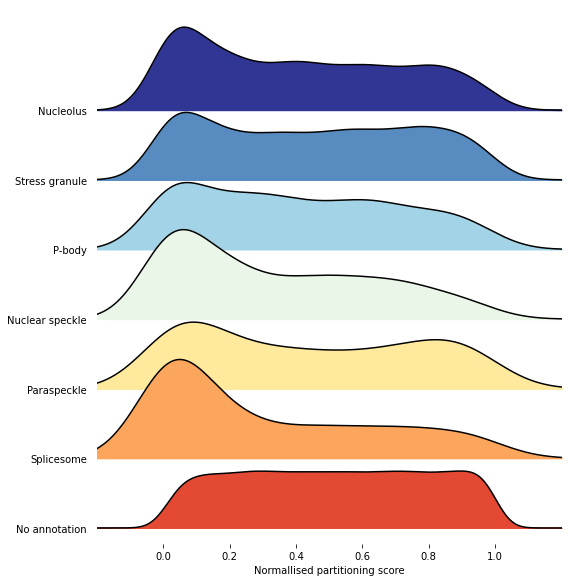

In [5]:
score_column = 'prediction_phys_rank'
predictions['prediction_phys_rank'] = predictions['prediction_phys2'].rank(ascending = False) / len(predictions)
MLOs = ['Nucleolus', 'Stress granule', 'P-body', 'Nuclear speckle', 'Paraspeckle', 'Splicesome']

for m in range(len(MLOs)):
    predictions[str(MLOs[m])] = np.where(predictions['Entry'].isin(MLO_annot_human['entry'][MLO_annot_human['MLO'] == MLOs[m]]),
                                True, False)
predictions['No annotation'] =  np.where(predictions['Entry'].isin(no_annot), True, False)
MLOs.append('No annotation')

# Create an empty list to collect data for Joy Plot
data_list = []
max_length = max(len(predictions[score_column][predictions[m] == True]) for m in MLOs)

# Generate and collect data for each MLO
for m in MLOs:
    data = predictions[score_column][predictions[m] == True].tolist()
    
    # Pad shorter lists with NaN values to match the maximum length
    if len(data) < max_length:
        data += [np.nan] * (max_length - len(data))
    
    data_list.append(data)

data_df = pd.DataFrame({MLOs[i]: data for i, data in enumerate(data_list)})
fig, axes = joypy.joyplot(data_df, figsize=(8, 8), colormap=plt.cm.RdYlBu_r)
plt.xlabel("Normallised partitioning score")
plt.savefig('Plots/score_distributions_MLOs.pdf')
plt.show()


# Construct condensate atlas

# 1. Read in interaction data

In [6]:
#Interaction matrix
IA_df2 = IA_df.set_index(list(IA_df)[0])
IA_df2.columns = IA_df2.iloc[0]
IA_df2 = IA_df2.iloc[2:]

#Map ENSP to Uniprot IDs
IA_df2 = IA_df2.rename(columns=mapping_dict)
IA_df2 = IA_df2.rename(index=mapping_dict)
#Remove proteins for which mapping to UniprotID cannot be performed:
IA_df3 = IA_df2[IA_df2.index.isin(predictions['Entry'])]
IA_df4 = IA_df3[IA_df3.columns[IA_df3.columns.isin(predictions['Entry'])]]

# 2. Cluster proteins based on interactions

In [7]:
#Calculate the correlation matrix based on interaction profiles and read it in:
df_corr = pd.read_csv('Data/String_DB/StringDB_correlation_matrix.csv')
df_corr = df_corr.rename(columns = {df_corr.columns[0]: 'protein_ID'})
df_corr = df_corr.set_index('protein_ID')

In [8]:
kmeans_50 = KMeans(n_clusters = 50, random_state=42).fit(df_corr)
kmeans_100 = KMeans(n_clusters = 100, random_state=0).fit(df_corr)
df_corr2 = df_corr.reset_index(drop = True)
cluster_df = pd.DataFrame({'number': df_corr2.index, 'ID': df_corr.index})
cluster_df['k_mean_cluster_50']  = kmeans_50.labels_
cluster_df['k_mean_cluster_100']  = kmeans_100.labels_
cluster_df.to_csv('Output/clusters.csv')

In [9]:
ids1 = predictions['Entry'][predictions['prediction_phys'] > 0.25]
ids2 = predictions['Entry'][predictions['DeePhase_score'] > 0.75]
ids = list(ids1) + list(ids2)

# 3. Consensus cluster & identify condensate clusters

In [10]:
#Read in data
cluster_df = pd.read_csv('Output/clusters.csv')
SC_score_dict = dict(zip(predictions['Entry'], predictions['DeePhase_score']))
score_column = 'prediction_phys'
COND_score_EF_dict = dict(zip(predictions['Entry'], predictions[score_column]))
cluster_df['SC_score'] = cluster_df['ID'].map(SC_score_dict)
cluster_df['CL_score'] = cluster_df['ID'].map(COND_score_EF_dict)

In [11]:
#Remove the large clusters:
large_cluster_index_100 = cluster_df['k_mean_cluster_100'].value_counts().index[0]
large_cluster_index_50 = cluster_df['k_mean_cluster_50'].value_counts().index[0]
print(cluster_df.shape)
ignore_proteins = cluster_df['ID'][(cluster_df['k_mean_cluster_50'] == large_cluster_index_50) &
           (cluster_df['k_mean_cluster_100'] == large_cluster_index_100)]
cluster_df_red = cluster_df[cluster_df['ID'].isin(ignore_proteins) == False]
print(cluster_df_red.shape)

#Check if two proteins are in the same cluster:
cond_prone_in_cluster_array = []; cluster_size_array = [];
cluster_index_50 = []; cluster_index_100 = []; IDs = []
for p in range(0, 100):
    for k in range(0, 50):
        df_cluster_temp = cluster_df_red[(cluster_df_red['k_mean_cluster_50'] == k) &
                                 (cluster_df_red['k_mean_cluster_100'] == p)]
        size_of_this_cluster = df_cluster_temp.shape[0]
        cluster_size_array.append(size_of_this_cluster)
        count_of_cond_prone = df_cluster_temp[(df_cluster_temp['SC_score'] > 0.75) |(df_cluster_temp['CL_score'] > 0.25)].shape[0]
        cond_prone_in_cluster_array.append(count_of_cond_prone)
        IDs.append(list(df_cluster_temp['ID']))
        cluster_index_50.append(k)
        cluster_index_100.append(p)
    

(18554, 7)
(15496, 7)


In [12]:
results_clustering = pd.DataFrame({'cluster_index_50': cluster_index_50,
                                  'cluster_index_100': cluster_index_100,
                                  'cluster_size': cluster_size_array,
                                  'cond_prone_protein_count': cond_prone_in_cluster_array,
                                  'proteins': IDs})
results_clustering = results_clustering[results_clustering['cluster_size'] > 7]
results_clustering['cond_fraction'] = results_clustering['cond_prone_protein_count'] / results_clustering['cluster_size'] 
results_clustering = results_clustering.reset_index(drop = True)
results_clustering_all = results_clustering.copy()
print(results_clustering_all.shape)
results_clustering = results_clustering[results_clustering['cond_fraction'] > 0.5]
print(results_clustering.shape)

(207, 6)
(86, 6)


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/663269594.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_clustering_all['cluster_size'], color = 'magenta')


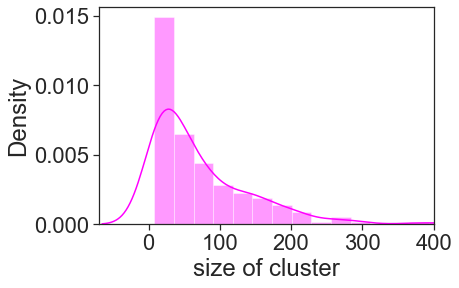

/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/663269594.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_clustering_all['cond_fraction'], color = 'cyan')


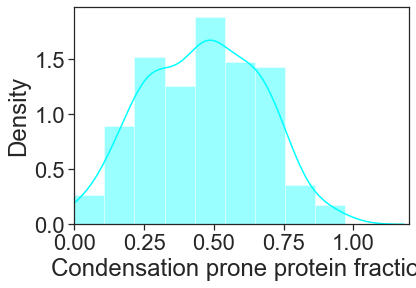

(86, 7)
6742


In [13]:
sns.set(style='white', font_scale=2)
sns.set_style('white', {'axes.linewidth': 0.5})
sns.set_style("ticks")
sns.distplot(results_clustering_all['cluster_size'], color = 'magenta')
plt.xlim([-70, 400])
plt.xlabel('size of cluster')
plt.savefig('Plots/cluster_size_distribution.pdf')
plt.show()

sns.distplot(results_clustering_all['cond_fraction'], color = 'cyan')
plt.xlim([0, 1.2])
plt.xlabel('Condensation prone protein fraction')
plt.savefig('Plots/cond_prone_fraction.pdf')
plt.show()

features = pd.read_csv('Data/Features/swissprot_features_and_predictions.csv')
features['Gene'] = features['Gene'].str.split(';').str[0]
convert_dict = dict(zip(features['Entry'], features['Gene']))
results_clustering['Genes'] = [list(pd.Series(x).map(convert_dict)) for x in results_clustering['proteins']]
results_clustering.to_excel('Output/condensate_clusters.xlsx')
print(results_clustering.shape)
print(np.sum(results_clustering['cluster_size']))

# 4. Characterise the clusters:

In [14]:
IA_data_start = pd.read_csv('Data/String_DB/9606.protein.links.v11.0.txt',  sep = ' ')
IA_df = pd.pivot_table(IA_data_start, index='protein1', columns='protein2', fill_value=0)

In [15]:
IA_df_binary = IA_df > 700
degree = list(np.sum(IA_df_binary, axis = 1))
mapping_df = pd.read_csv('Data/Biogrid/uniprot_to_ensp.txt', sep = '\t')
mapping_dict = dict(zip(mapping_df['To'], mapping_df['From']))
IDs = IA_df_binary.index.map(mapping_dict)
degree_dict = dict(zip(IDs, degree))
predictions['prediction_phys_rank'] = predictions['prediction_phys'].rank(ascending=True) / len(predictions)

score1_dict = dict(zip(predictions['Entry'], predictions['DeePhase_score']))
score2_dict = dict(zip(predictions['Entry'], predictions['prediction_phys_rank']))

In [16]:
predictions['degree'] = predictions['Entry'].map(degree_dict)
predictions = predictions[predictions['degree'].notna()]
predictions['cond_prone'] = np.where((predictions['DeePhase_score'] > 0.75)|(predictions['prediction_phys'] > 0.30), True, False)
proteins_in_clusters = results_clustering['proteins'].explode().tolist()
predictions['in_cluster'] = np.where(predictions['Entry'].isin(proteins_in_clusters), True, False)

In [17]:
results_clustering['degrees'] = results_clustering['proteins'].apply(lambda x: [degree_dict[i] for i in x if i in degree_dict])
results_clustering['mean_degree'] = results_clustering['degrees'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)

results_clustering['DeePhase_score'] = results_clustering['proteins'].apply(lambda x: [score1_dict[i] for i in x if i in score1_dict])
results_clustering['mean_DeePhase_score'] = results_clustering['DeePhase_score'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)

results_clustering['prediction_phys_rank'] = results_clustering['proteins'].apply(lambda x: [score2_dict[i] for i in x if i in score2_dict])
results_clustering['mean_prediction_phys'] = results_clustering['prediction_phys_rank'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)

/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/194713795.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions['degree'][predictions['category2'] == 'Not in cluster'], label = 'Not in condensate')
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/194713795.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/m

(-30.0, 500.0)

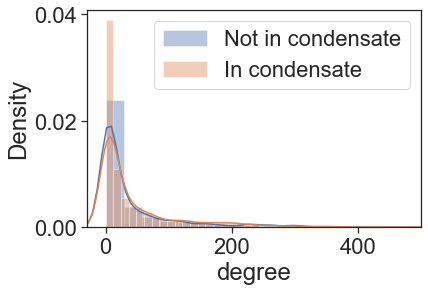

In [18]:
predictions['category'] = np.where(predictions['DeePhase_score'] > 0.75, 'Cond. scaffold', np.NaN)
predictions['category'] = np.where((predictions['DeePhase_score'] < 0.75) &
                                   (predictions['in_cluster'] == True), 'in cluster, not scaffold', predictions['category'])
predictions['category'] = np.where(predictions['in_cluster'] == False, 'not in cluster', predictions['category'])
category_dict = dict(zip(predictions['Entry'], predictions['category']))
predictions['category2'] = np.where(predictions['category'] == 'not in cluster', 'Not in cluster', 'In condensate')
sns.distplot(predictions['degree'][predictions['category2'] == 'Not in cluster'], label = 'Not in condensate')
sns.distplot(predictions['degree'][predictions['category2'] == 'In condensate'], label = 'In condensate')
plt.legend()
plt.xlim([-30, 500])

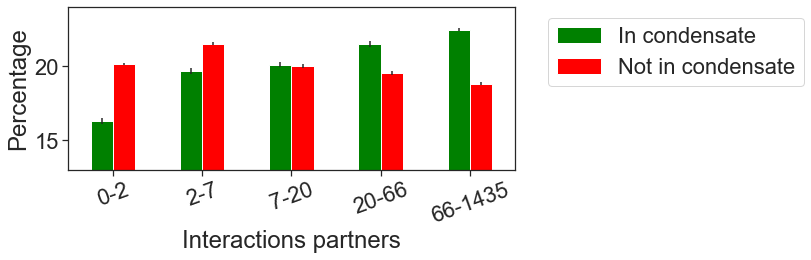

In [19]:
pivots_comb = pd.DataFrame()
num_bins = 5
percentiles = np.linspace(0, 100, num_bins + 1)

for k in range(0, 10):
    predictions_plot = predictions.sample(frac=0.9, random_state=k)
    bin_edges = np.percentile(predictions_plot['degree'], percentiles)
    bin_indices = np.digitize(predictions_plot['degree'], bin_edges)
    predictions_plot['degree_bin'] = bin_indices

    data = predictions_plot[['degree_bin', 'category2']]
    data = data[data['degree_bin'] <= num_bins]
    dfp = data.pivot_table(index='degree_bin', columns='category2', values='category2', aggfunc='size') 
    dfp['In condensate'] = dfp['In condensate'] / np.sum(dfp['In condensate']) * 100
    dfp['Not in condensate']  = dfp['Not in cluster'] / np.sum(dfp['Not in cluster']) * 100
    pivots_comb = pd.concat([pivots_comb, dfp], axis = 0)
pivots_comb = pivots_comb.reset_index()


grouped_means = pivots_comb.groupby('degree_bin').agg({'In condensate': 'mean', 'Not in condensate': 'mean'})
grouped_stds = pivots_comb.groupby('degree_bin').agg({'In condensate': 'std', 'Not in condensate': 'std'})
grouped_means = grouped_means.reset_index()
grouped_stds = grouped_stds.reset_index()

colors = ['green', 'red']
ax = grouped_means[['In condensate', 'Not in condensate']].plot(kind='bar', figsize=(8, 3), rot=20,
                        yerr=[grouped_stds['In condensate'], grouped_stds['Not in condensate']],
                                                                       color = colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Interactions partners')
plt.ylabel('Percentage')
ax.set_xticklabels([str(int(bin_edges[i])) + '-' + str(int(bin_edges[i+1])) for i in range(len(percentiles) -1)])
plt.ylim([13, 24])
plt.savefig('Plots/degree_dist_in_and_out_of_condensates.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Validation

#  Are clusters overlapping with previously characterised MLOs?

In [20]:
#add SG core info:
SG_core = pd.read_excel('Data/SG/SG_core.xlsx')
SG_core_df = pd.DataFrame({'entry': SG_core['UniProtKB'],
                        'MLO': ['Stress granule core']*len(SG_core)})
MLO_annot_human_updated = pd.concat([MLO_annot_human, SG_core_df])
MLOs = MLO_annot_human_updated['MLO'].value_counts().index[MLO_annot_human_updated['MLO'].value_counts() >=10]


#Calculate enrichment values (2D array of # different types of MLOs X # clusters)
enrichment_values = np.zeros((results_clustering.shape[0], len(MLOs)))
for p in range(0, results_clustering.shape[0]):
    for k in range(0, len(MLOs)):
        MLO_of_interest = MLO_annot_human_updated['entry'][MLO_annot_human_updated['MLO'] == MLOs[k]]
        total = len(MLO_of_interest)
        cluster_here = pd.Series(results_clustering['proteins'].iloc[p])
        observed = cluster_here.isin(MLO_of_interest).sum()
        random_expected =  total / cluster_df_red['ID'].shape[0] * len(cluster_here)
        enrich_here = observed / random_expected
        enrichment_values[p, k] = enrich_here
        
#Results into a dataframe:
result_df = pd.DataFrame(enrichment_values)
result_df.columns = MLOs
result_df = result_df.reset_index(drop = True)
print(result_df.shape)
result_df['max'] = np.max(result_df[result_df.columns[:-1]], axis = 1)
result_df[result_df['P-body'] > 10.5]

(86, 16)


,Nucleolus,Stress granule,P-body,Nuclear speckle,Paraspeckle,Splicesome,Nuclear stress body,PML nuclear body,Nuclear body,Stress granule core,Cajal body,SMN complex,IMP1 ribonucleoprotein granule,Nuclear pore complex,Viroplasm,Sam68 nuclear body,max
9,4.474917,7.071186,10.734005,19.434783,12.34741,37.795122,12.852133,0.0,31.841096,22.296403,3.228333,19.37,69.178571,0.0,0.0,77.48,69.178571


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/3954214575.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_columns).colors  # Using a colormap with enough discrete colors


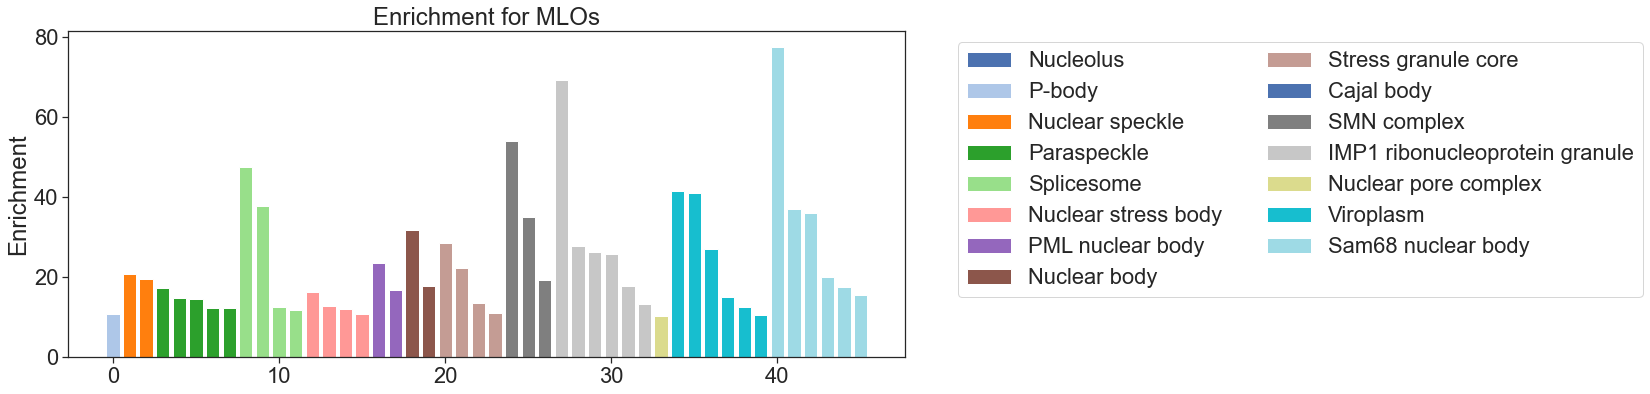

In [22]:
df = result_df.drop(columns = ['max', 'Stress granule'])
# Adjusting the plot to order values within each column in descending order and adding a legend

num_columns = len(df.columns)
colors = plt.cm.get_cmap('tab20', num_columns).colors  # Using a colormap with enough discrete colors


plt.figure(figsize=(15, 6))
bar_positions = 0  # starting position for the first set of bars
for i, col in enumerate(df.columns):
    values = df[col][df[col] > 10].sort_values(ascending=False).reset_index(drop=True)
    bars = plt.bar(x=np.arange(bar_positions, bar_positions + len(values)), height=values, color=colors[i], label=col)
    bar_positions += len(values)

plt.title('Enrichment for MLOs')
plt.ylabel('Enrichment')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols = 2)
plt.savefig('Plots/Max_enrichment_MLOs.pdf')
plt.show()


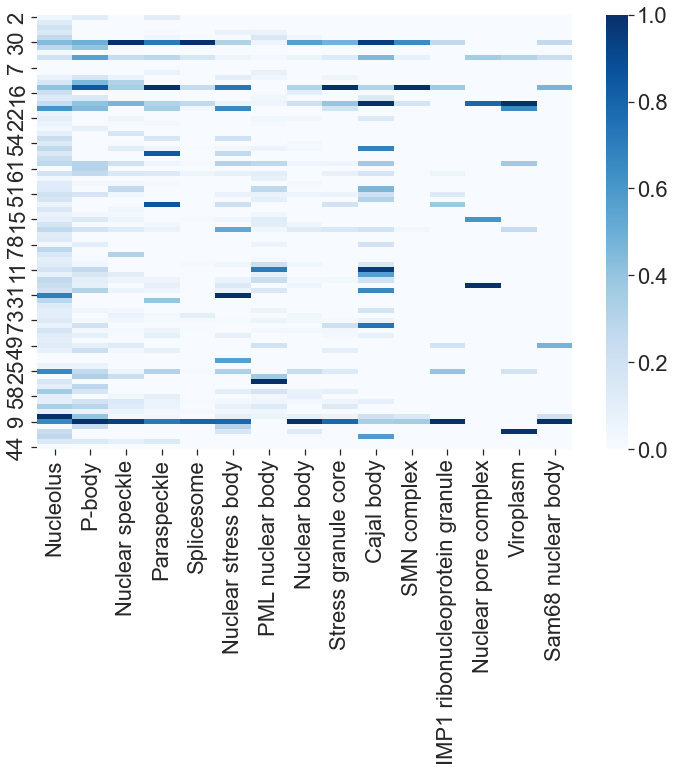

In [23]:
plt.figure(figsize=(12, 8))
result_df_plot = df.copy()
result_df_plot = result_df_plot.mask(result_df_plot < 0, 0)
result_df_norm = result_df_plot.div(result_df_plot.max())
result_df_norm = result_df_norm.sample(n=len(result_df_norm), random_state=0)
clustermap = sns.heatmap(result_df_norm, cmap='Blues')
plt.savefig('Plots/MLO_enrichments.pdf')

In [24]:
nucleolous_df = pd.read_excel('Data/Nucleolous/41586_2023_5767_MOESM4_ESM.xlsx')
#nucleolous_df['Localization in this paper'].value_counts()

ID_df = pd.read_csv('Data/Nucleolous/uniprot_to_ENSG.txt', sep = '\t')
ID_dict = dict(zip(ID_df['To'], ID_df['From']))
nucleolous_df['Entry'] = nucleolous_df['Ensembl Gene ID'].map(ID_dict)

NR = nucleolous_df['Entry'][nucleolous_df['Localization in this paper'].str.contains('NR')]
PNC = nucleolous_df['Entry'][nucleolous_df['Localization in this paper'].str.contains('PNC')]
GC = nucleolous_df['Entry'][nucleolous_df['Localization in this paper'].str.contains('GC')]
PDFC = nucleolous_df['Entry'][nucleolous_df['Localization in this paper'].str.contains('PDFC')]
DFC = nucleolous_df['Entry'][nucleolous_df['Localization in this paper'].str.contains('DFC')]
DFC = DFC[DFC.isin(PDFC) == False]
FC = nucleolous_df['Entry'][nucleolous_df['Localization in this paper'].str.contains('FC')]
FC = DFC[(DFC.isin(PDFC) == False) | (DFC.isin(DFC) == False) | (DFC.isin(GC) == False)]

indices_dict_NR = {id_of_interest: results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index[0] 
                for id_of_interest in NR if not results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index.empty}.values()
indices_dict_PNC = {id_of_interest: results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index[0] 
                for id_of_interest in PNC if not results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index.empty}.values()
indices_dict_GC = {id_of_interest: results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index[0] 
                for id_of_interest in GC if not results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index.empty}.values()
indices_dict_PDFC = {id_of_interest: results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index[0] 
                for id_of_interest in PDFC if not results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index.empty}.values()
indices_dict_DFC = {id_of_interest: results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index[0] 
                for id_of_interest in DFC if not results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index.empty}.values()
indices_dict_FC = {id_of_interest: results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index[0] 
                for id_of_interest in FC if not results_clustering[results_clustering['proteins'].apply(lambda x: id_of_interest in x)].index.empty}.values()

In [25]:
nucleolar_comparts = [NR, PNC, GC, PDFC, DFC, FC]

#Calculate enrichment values (2D array of # different types of MLOs X # clusters)
enrichment_values_nucl = np.zeros((results_clustering.shape[0], len(nucleolar_comparts)))
for p in range(0, results_clustering.shape[0]):
    for k in range(0, len(nucleolar_comparts)):
        MLO_of_interest = nucleolar_comparts[k]
        total = len(MLO_of_interest)
        cluster_here = pd.Series(results_clustering['proteins'].iloc[p])
        observed = cluster_here.isin(MLO_of_interest).sum()
        random_expected =  total / cluster_df_red['ID'].shape[0] * len(cluster_here)
        enrich_here = observed / random_expected
        enrichment_values_nucl[p, k] = enrich_here
        
#Results into a dataframe:
nucl_df = pd.DataFrame(enrichment_values_nucl)
nucleolar_comparts_names = ['NR', 'PNC', 'GC', 'PDFC', 'DFC', 'FC']
nucl_df.columns = nucleolar_comparts_names
nucl_df = nucl_df.reset_index(drop = True)
nucl_df['max'] = np.max(nucl_df[nucl_df.columns[:-1]], axis = 1)

result_comb_df = pd.concat([result_df.drop(columns = 'max'), nucl_df.drop(columns = 'max')], axis = 1)

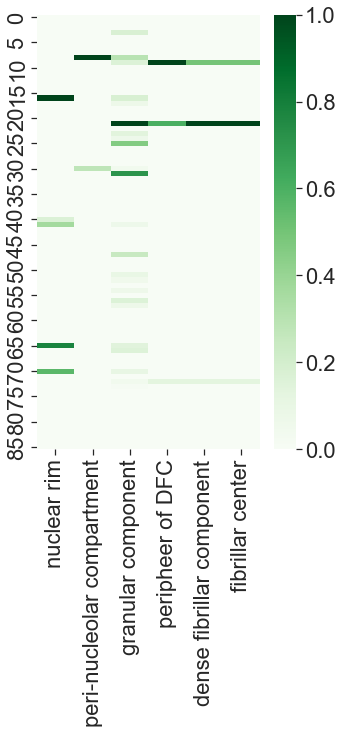

In [26]:
plt.figure(figsize=(5, 8))
nucl_df_plot = nucl_df[nucl_df.columns[:6]]
nucleolar_comparts_names = ['NR', 'PNC', 'GC', 'PDFC', 'DFC', 'FC']
name_dict = dict({'NR': 'nuclear rim',
'FC': 'fibrillar center',
'DFC': 'dense fibrillar component',
'GC': 'granular component',
'PNC': 'peri-nucleolar compartment',
'PDFC': 'peripheer of DFC'})
nucl_df_plot.columns = pd.Series(nucleolar_comparts_names).map(name_dict)
nucl_df_norm = nucl_df_plot.div(nucl_df_plot.max())
clustermap = sns.heatmap(nucl_df_norm, cmap='Greens')
plt.savefig('Plots/nucl_enrichments.pdf')

# Cytoscape visuals

# 1. Highlight that clusters are enriched in proteins that comes from the same MLO

In [27]:
#Make a dataframe that focuses on a specific MLO
    # 1. Find all clusters into which this MLO is enriched and show PPIs within these clusters
    # 2. Add cluster values for all clusters

In [30]:
#IA_data_start = pd.read_csv('../proteins_v2/String_DB/9606.protein.links.v11.0.txt',  sep = ' ')
IA_data_filt = IA_data_start[IA_data_start['combined_score'] > 800]
IA_data_filt['Entry1'] = IA_data_filt['protein1'].map(mapping_dict);
IA_data_filt['Entry2'] = IA_data_filt['protein2'].map(mapping_dict)
ID_dict2 = dict(zip(features['Entry'], features['Gene']))
ID_dict3 = dict(zip(features['Gene'], features['Entry']))
IA_data_filt['Gene1'] = IA_data_filt['Entry1'].map(ID_dict2);
IA_data_filt['Gene2'] = IA_data_filt['Entry2'].map(ID_dict2)
IA_data_filt = IA_data_filt[IA_data_filt['Gene1'].notna()];
IA_data_filt = IA_data_filt[IA_data_filt['Gene2'].notna()]

degree = IA_df_binary.sum(axis = 1)
indeces = IA_df_binary.index
degree_dict = dict(zip(indeces, degree))

results_clustering['cluster_ID'] = results_clustering.index.copy()
exploded_df = results_clustering[['cluster_ID', 'proteins']].explode('proteins')
cluster_ID_dict = dict(zip(exploded_df['proteins'], exploded_df['cluster_ID']))

flat_list = results_clustering['proteins'].explode().tolist()
IAs_cond_prone = IA_data_filt[IA_data_filt['Entry1'].isin(flat_list)]
IAs_cond_prone = IAs_cond_prone[IAs_cond_prone['Entry2'].isin(flat_list)]

/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/877345301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IA_data_filt['Entry1'] = IA_data_filt['protein1'].map(mapping_dict);
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/877345301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IA_data_filt['Entry2'] = IA_data_filt['protein2'].map(mapping_dict)
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/877345301.py:7: SettingWithCopyWarning: 
A value is tryi

In [47]:
MLO_here = 'Splicesome'
genes_in_MLO = MLO_annot_human['entry'][MLO_annot_human['MLO'] == MLO_here].map(ID_dict2)
print(len(genes_in_MLO))
MLO_IAs = IAs_cond_prone[(IAs_cond_prone['Gene1'].isin(genes_in_MLO)) | (IAs_cond_prone['Gene2'].isin(genes_in_MLO))]
MLO_IAs = MLO_IAs[~MLO_IAs[['Entry1', 'Entry2']].apply(frozenset, axis=1).duplicated()]
MLO_IAs = MLO_IAs[MLO_IAs['Gene1'].notna()]
MLO_IAs = MLO_IAs[MLO_IAs['Gene2'].notna()]

MLO_here_IAs = MLO_IAs.copy()
new_data = pd.DataFrame(columns = MLO_here_IAs.columns)
extra_IDs = list(set(MLO_here_IAs['Entry2'][MLO_here_IAs['Entry2'].isin(MLO_here_IAs['Gene1']) == False]))
new_data['Entry1'] = extra_IDs
new_data['Gene1'] = new_data['Entry1'].map(ID_dict2)
MLO_here_IAs = pd.concat([MLO_here_IAs, new_data], ignore_index=True)
MLO_here_IAs['cluster_ID'] = MLO_here_IAs['Entry1'].map(cluster_ID_dict)
MLO_here_IAs['degree'] = MLO_here_IAs['Entry1'].map(degree_dict)
MLO_here_IAs['MLO_annot'] = np.where(MLO_here_IAs['Entry1'].isin(MLO_annot_human['entry'][MLO_annot_human['MLO'] == MLO_here]),
         True, False)
MLO_here_IAs[['Gene1', 'Gene2', 'cluster_ID', 'degree', 'MLO_annot']].to_csv('Cytoscape/cytoscape_data_' + str(MLO_here) + '.csv')

246


In [48]:
MLO_here = 'Nucleolus'
genes_in_MLO = MLO_annot_human['entry'][MLO_annot_human['MLO'] == MLO_here].map(ID_dict2)
print(len(genes_in_MLO))
MLO_IAs = IAs_cond_prone[(IAs_cond_prone['Gene1'].isin(genes_in_MLO)) | (IAs_cond_prone['Gene2'].isin(genes_in_MLO))]
MLO_IAs = MLO_IAs[~MLO_IAs[['Entry1', 'Entry2']].apply(frozenset, axis=1).duplicated()]
MLO_IAs = MLO_IAs[MLO_IAs['Gene1'].notna()]
MLO_IAs = MLO_IAs[MLO_IAs['Gene2'].notna()]

MLO_here_IAs = MLO_IAs.copy()
new_data = pd.DataFrame(columns = MLO_here_IAs.columns)
extra_IDs = list(set(MLO_here_IAs['Entry2'][MLO_here_IAs['Entry2'].isin(MLO_here_IAs['Gene1']) == False]))
new_data['Entry1'] = extra_IDs
new_data['Gene1'] = new_data['Entry1'].map(ID_dict2)
MLO_here_IAs = pd.concat([MLO_here_IAs, new_data], ignore_index=True)
MLO_here_IAs['cluster_ID'] = MLO_here_IAs['Entry1'].map(cluster_ID_dict)
MLO_here_IAs['degree'] = MLO_here_IAs['Entry1'].map(degree_dict)
MLO_here_IAs['MLO_annot'] = np.where(MLO_here_IAs['Entry1'].isin(MLO_annot_human['entry'][MLO_annot_human['MLO'] == MLO_here]),
         True, False)
MLO_here_IAs[['Gene1', 'Gene2', 'cluster_ID', 'degree', 'MLO_annot']].to_csv('Cytoscape/cytoscape_data_' + str(MLO_here) + '.csv')

1818


# Compare and visualise interactions within a single cluster

In [33]:
IA_data_filt = IA_data_start[IA_data_start['combined_score'] > 700]
IA_data_filt['Entry1'] = IA_data_filt['protein1'].map(mapping_dict);
IA_data_filt['Entry2'] = IA_data_filt['protein2'].map(mapping_dict)
IA_data_filt['Gene1'] = IA_data_filt['Entry1'].map(ID_dict2);
IA_data_filt['Gene2'] = IA_data_filt['Entry2'].map(ID_dict2)

cluster_ID = 66
cytoscape_example_cluster = results_clustering['proteins'][results_clustering.index == cluster_ID].iloc[0]
IAs_example_MLO = IA_data_filt[IA_data_filt['Entry1'].isin(cytoscape_example_cluster)]
IAs_example_MLO = IAs_example_MLO[IAs_example_MLO['Entry2'].isin(cytoscape_example_cluster)]

genes_in_cluster = list(pd.Series(cytoscape_example_cluster).map(ID_dict2))
print(len(genes_in_cluster))

cluster_IAs = IA_data_filt[(IA_data_filt['Gene1'].isin(genes_in_cluster)) & (IA_data_filt['Gene2'].isin(genes_in_cluster))]
cluster_IAs = cluster_IAs[~cluster_IAs[['Entry1', 'Entry2']].apply(frozenset, axis=1).duplicated()]
cluster_IAs = cluster_IAs[cluster_IAs['Gene1'].notna()]
cluster_IAs = cluster_IAs[cluster_IAs['Gene2'].notna()]

cluster_IAs_here = cluster_IAs.copy()
new_data = pd.DataFrame(columns = cluster_IAs_here.columns)
extra_IDs = list(set(cluster_IAs_here['Entry2'][cluster_IAs_here['Entry2'].isin(cluster_IAs_here['Entry1']) == False]))
new_data['Entry1'] = extra_IDs
new_data['Gene1'] = new_data['Entry1'].map(ID_dict2)
cluster_IAs = pd.concat([cluster_IAs_here, new_data], ignore_index=True)
cluster_IAs['category_protein1'] = cluster_IAs['Entry1'].map(category_dict)
single_df = cluster_IAs.drop_duplicates(subset = 'Gene1')

degree_dict_cluster = dict(zip(cluster_IAs['Gene1'].value_counts().index,
                          cluster_IAs['Gene1'].value_counts().values))
cluster_IAs['degree_protein1'] = cluster_IAs['Gene1'].map(degree_dict_cluster)
cluster_IAs[['Gene1', 'Gene2', 'category_protein1', 'degree_protein1']].to_csv('Cytoscape/cytoscape_data_cluster_' + str(cluster_ID) + '.csv')

/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/2180694121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IA_data_filt['Entry1'] = IA_data_filt['protein1'].map(mapping_dict);
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/2180694121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IA_data_filt['Entry2'] = IA_data_filt['protein2'].map(mapping_dict)
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/2180694121.py:4: SettingWithCopyWarning: 
A value is t

94
45.58510638297872


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/3640641963.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cluster_IAs['degree_protein1'][cluster_IAs['category_protein1'] == 'in cluster, not scaffold'],
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_50022/3640641963.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/m

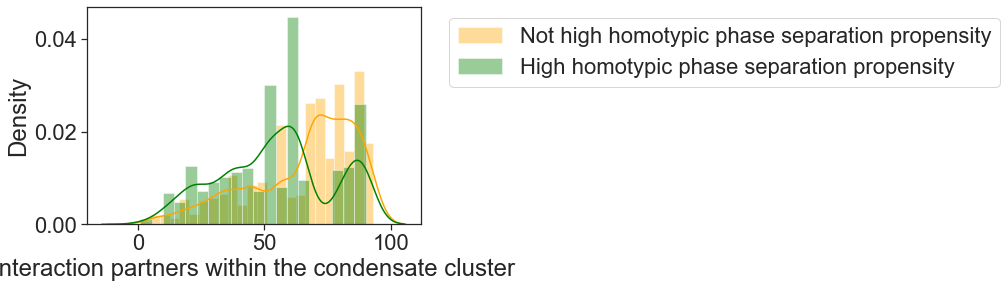

In [34]:
sns.distplot(cluster_IAs['degree_protein1'][cluster_IAs['category_protein1'] == 'in cluster, not scaffold'],
             label = 'Not high homotypic phase separation propensity', color = 'orange')
sns.distplot(cluster_IAs['degree_protein1'][cluster_IAs['category_protein1'] == 'Cond. scaffold'],
             label = 'High homotypic phase separation propensity',  color = 'green')
plt.xlabel('Interaction partners within the condensate cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('Plots/degree_dist_in_exemplary_condensate_cluster.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [35]:
#Iterate over all clusters

In [45]:
cluster_IA_comb = pd.DataFrame()
results_clustering = results_clustering.reset_index(drop = True)
for k in range(0, len(results_clustering)):
    cluster_ID = k
    cytoscape_example_cluster = results_clustering['proteins'][results_clustering.index == cluster_ID].iloc[0]
    IAs_example_MLO = IA_data_filt[IA_data_filt['Entry1'].isin(cytoscape_example_cluster)]
    IAs_example_MLO = IAs_example_MLO[IAs_example_MLO['Entry2'].isin(cytoscape_example_cluster)]
    genes_in_cluster = list(pd.Series(cytoscape_example_cluster).map(ID_dict2))
    cluster_IAs = IA_data_filt[(IA_data_filt['Gene1'].isin(genes_in_cluster)) & (IA_data_filt['Gene2'].isin(genes_in_cluster))]
    cluster_IAs = cluster_IAs[(cluster_IAs['Entry1'].notna()) & (cluster_IAs['Entry2'].notna())
                             & (cluster_IAs['Gene1'].notna()) & (cluster_IAs['Gene2'].notna())]
    
    degree_dict_cluster = dict(zip(cluster_IAs['Gene1'].value_counts().index,
                              cluster_IAs['Gene1'].value_counts().values / len(cluster_IAs['Gene1'].unique())))
    cluster_IAs['degree_protein1'] = cluster_IAs['Gene1'].map(degree_dict_cluster)
    cluster_IAs['category_protein1'] = cluster_IAs['Entry1'].map(category_dict)
    cluster_IAs['cluster_ID'] = cluster_ID
    cluster_IA_comb = pd.concat([cluster_IA_comb, cluster_IAs.drop_duplicates(subset = 'Gene1')], axis = 0)

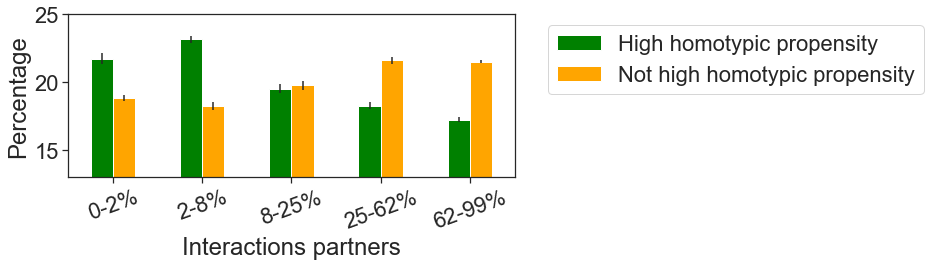

In [46]:
pivots_comb = pd.DataFrame()
percentiles = [0, 20, 40, 60, 80, 100]

for k in range(0, 10):
    num_bins = len(percentiles)
    cluster_IA_plot = cluster_IA_comb.sample(frac=0.9, random_state=k)
    bin_edges = np.percentile(cluster_IA_plot['degree_protein1'], percentiles)
    # Create an array to hold the indices of the bin to which each data point belongs
    bin_indices = np.digitize(cluster_IA_plot['degree_protein1'], bin_edges)
    cluster_IA_plot['degree_bin'] = bin_indices
    data = cluster_IA_plot[['degree_bin', 'category_protein1']]
    data = data[data['degree_bin'] <= num_bins - 1]
    dfp = data.pivot_table(index='degree_bin', columns='category_protein1', values='category_protein1', aggfunc='size') 
    dfp['High homotypic propensity'] = dfp['Cond. scaffold'] / np.sum(dfp['Cond. scaffold']) * 100
    dfp['Not high homotypic propensity']  = dfp['in cluster, not scaffold'] / np.sum(dfp['in cluster, not scaffold']) * 100
    pivots_comb = pd.concat([pivots_comb, dfp], axis = 0)
pivots_comb = pivots_comb.reset_index()
grouped_means = pivots_comb.groupby('degree_bin').agg({'High homotypic propensity': 'mean',
                                                       'Not high homotypic propensity': 'mean'})
grouped_stds = pivots_comb.groupby('degree_bin').agg({'High homotypic propensity': 'std',
                                                      'Not high homotypic propensity': 'std'})
grouped_means = grouped_means.reset_index()
grouped_stds = grouped_stds.reset_index()

colors = ['green', 'orange']

ax = grouped_means[['High homotypic propensity', 'Not high homotypic propensity']].plot(kind='bar', figsize=(8, 3), rot=20,
                        yerr=[grouped_stds['High homotypic propensity'],
                              grouped_stds['Not high homotypic propensity']],
                                                                       color = colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Interactions partners')
plt.ylabel('Percentage')
ax.set_xticklabels([str(int(100*bin_edges[i])) + '-' + str(int(100*bin_edges[i+1])) + '%'  for i in range(len(percentiles) -1)])
plt.ylim([13, 25])
plt.savefig('Plots/degree_dist_in_condensates.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()